In [4]:
import os
import glob
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random

DATA_DIR = "../external"
ACTIVITIES = ["Sit", "Walk", "Stair-up"]
SAMPLING_RATE = 100
OVERLAP = 0.5
CHUNK_SIZE = 1  
BATCH_SIZE = 32
EPOCHS = 100
LEARNING_RATE = 0.001

In [ ]:
# Load the dataset and preprocess it
def load_activity_data():
    data_raw, labels = [], []
    for idx, activity in enumerate(ACTIVITIES):
        folder = os.path.join(DATA_DIR, activity)
        files = glob.glob(os.path.join(folder, "*.csv"))
        for f in files:
            df = pd.read_csv(f, header=None)
            df.columns = ["time1","acc_x","acc_y","acc_z","time2","gyr_x","gyr_y","gyr_z"]
            df = df.drop(columns=["time1","time2"])  # keep only acc/gyr
            data_raw.append(df)
            labels.append(idx)
    return data_raw, labels

def balance_classes(data_raw, labels):
    grouped = {i: [] for i in range(len(ACTIVITIES))}
    for d, l in zip(data_raw, labels):
        grouped[l].append(d)

    min_count = min(len(grouped[i]) for i in grouped)

    # Downsample all classes to equal size
    balanced_data, balanced_labels = [], []
    for cls, dfs in grouped.items():
        chosen = random.sample(dfs, min_count)
        balanced_data.extend(chosen)
        balanced_labels.extend([cls]*len(chosen))

    return balanced_data, balanced_labels

# Chunking the data
def chunk_data_raw(data_raw, labels, chunk_size_sec, sampling_rate, overlap=OVERLAP):
    data, y = [], []
    chunk_samples = int(chunk_size_sec * sampling_rate)
    step = int(chunk_samples * (1 - overlap))
    for i, df in enumerate(data_raw):
        for start in range(0, len(df) - chunk_samples + 1, step):
            chunk = df.iloc[start:start+chunk_samples]
            if len(chunk) == chunk_samples:
                data.append(chunk.values)
                y.append(labels[i])
    return np.array(data), np.array(y)

In [ ]:
# Positional encoding of the transformer
class PositionalEncoding(nn.Module):
    def __init__(self, emb_size, dropout=0.1, maxlen=5000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        pe = torch.zeros(maxlen, emb_size)
        position = torch.arange(0, maxlen, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, emb_size, 2).float() * (-math.log(10000.0) / emb_size))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

# Transformer model
class TransformerClassifier(nn.Module):
    def __init__(self, input_dim=6, emb_size=32, nhead=4, nhid=64, nlayers=2, nclasses=len(ACTIVITIES), dropout=0.3):
        super().__init__()
        self.embedding = nn.Sequential(
            nn.Linear(input_dim, emb_size),
            nn.LayerNorm(emb_size)
        )
        self.pos_encoder = PositionalEncoding(emb_size, dropout)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=emb_size, nhead=nhead, dim_feedforward=nhid,
            dropout=dropout, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=nlayers)
        self.dropout_fc = nn.Dropout(0.3)
        self.classifier = nn.Sequential(
            nn.Linear(emb_size, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, nclasses)
        )
        self.emb_size = emb_size

    def forward(self, x):
        x = self.embedding(x) * math.sqrt(self.emb_size)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        x = self.dropout_fc(x)
        return self.classifier(x)

In [ ]:
def train_and_evaluate():
    data_raw, labels = load_activity_data()
    data_raw, labels = balance_classes(data_raw, labels)

    X, y = chunk_data_raw(data_raw, labels, CHUNK_SIZE, SAMPLING_RATE)

    # Train-test split 80/20
    X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(X, y, test_size=0.2, stratify=y)

    # Normalize
    scaler = StandardScaler()
    X_train_np = scaler.fit_transform(X_train_np.reshape(-1, 6)).reshape(X_train_np.shape)
    X_test_np = scaler.transform(X_test_np.reshape(-1, 6)).reshape(X_test_np.shape)

    X_train = torch.tensor(X_train_np, dtype=torch.float32)
    y_train = torch.tensor(y_train_np, dtype=torch.long)
    X_test = torch.tensor(X_test_np, dtype=torch.float32)
    y_test = torch.tensor(y_test_np, dtype=torch.long)

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=BATCH_SIZE)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = TransformerClassifier().to(device)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

    warmup_epochs = 10
    total_epochs = EPOCHS
    train_acc_history, val_acc_history = [], []

    # Training loop
    for epoch in range(total_epochs):
        # LR scheduling with warmup + cosine decay
        if epoch < warmup_epochs:
            lr_scale = 0.1 + 0.9 * (epoch / warmup_epochs)
        else:
            lr_scale = 0.5 * (1 + math.cos(math.pi * (epoch - warmup_epochs) / (total_epochs - warmup_epochs)))
        for pg in optimizer.param_groups:
            pg['lr'] = LEARNING_RATE * lr_scale

        model.train()
        total_correct, total = 0, 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_correct += (preds.argmax(dim=1) == yb).sum().item()
            total += yb.size(0)
        train_acc = total_correct / total * 100
        train_acc_history.append(train_acc)

        # Validation on test split
        model.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for xb, yb in test_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                val_correct += (preds.argmax(dim=1) == yb).sum().item()
                val_total += yb.size(0)
        val_acc = val_correct / val_total * 100
        val_acc_history.append(val_acc)

        print(f"Epoch {epoch+1}/{total_epochs} | LR: {optimizer.param_groups[0]['lr']:.6f} "
              f"| Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    # Plot train history
    plt.figure(figsize=(7,5))
    plt.plot(range(1, total_epochs+1), train_acc_history, label='Train Accuracy', marker='o')
    plt.plot(range(1, total_epochs+1), val_acc_history, label='Validation Accuracy', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy per Epoch')
    plt.ylim(0, 105)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.show()

    # Final Test Eval with classification report and confusion matrix
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            all_preds.extend(preds.argmax(dim=1).cpu().numpy())
            all_labels.extend(yb.cpu().numpy())

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=ACTIVITIES, zero_division=0))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=ACTIVITIES, yticklabels=ACTIVITIES)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

Epoch 1/100 | LR: 0.000100 | Train Acc: 79.90% | Val Acc: 88.08%
Epoch 2/100 | LR: 0.000190 | Train Acc: 88.10% | Val Acc: 88.08%
Epoch 3/100 | LR: 0.000280 | Train Acc: 94.12% | Val Acc: 96.54%
Epoch 4/100 | LR: 0.000370 | Train Acc: 97.63% | Val Acc: 96.38%
Epoch 5/100 | LR: 0.000460 | Train Acc: 97.88% | Val Acc: 96.30%
Epoch 6/100 | LR: 0.000550 | Train Acc: 97.95% | Val Acc: 96.34%
Epoch 7/100 | LR: 0.000640 | Train Acc: 98.27% | Val Acc: 96.42%
Epoch 8/100 | LR: 0.000730 | Train Acc: 98.49% | Val Acc: 96.22%
Epoch 9/100 | LR: 0.000820 | Train Acc: 98.46% | Val Acc: 98.78%
Epoch 10/100 | LR: 0.000910 | Train Acc: 98.57% | Val Acc: 98.47%
Epoch 11/100 | LR: 0.001000 | Train Acc: 98.71% | Val Acc: 98.03%
Epoch 12/100 | LR: 0.001000 | Train Acc: 98.52% | Val Acc: 97.92%
Epoch 13/100 | LR: 0.000999 | Train Acc: 98.79% | Val Acc: 97.13%
Epoch 14/100 | LR: 0.000997 | Train Acc: 98.65% | Val Acc: 98.66%
Epoch 15/100 | LR: 0.000995 | Train Acc: 98.71% | Val Acc: 98.19%
Epoch 16/100 | LR: 

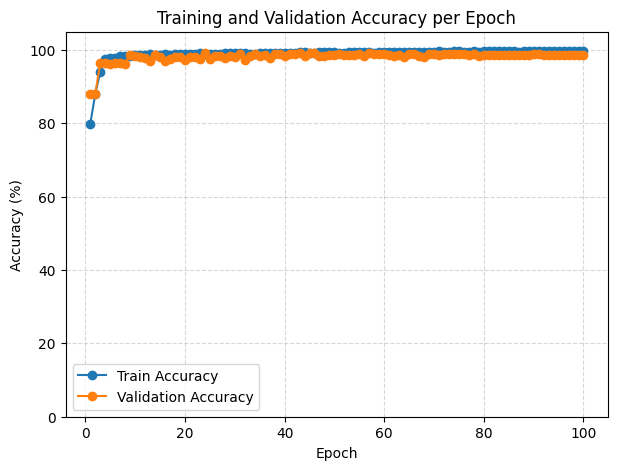


Classification Report:
              precision    recall  f1-score   support

         Sit       1.00      1.00      1.00      1297
        Walk       0.92      0.98      0.95       300
    Stair-up       1.00      0.97      0.98       945

    accuracy                           0.99      2542
   macro avg       0.97      0.99      0.98      2542
weighted avg       0.99      0.99      0.99      2542



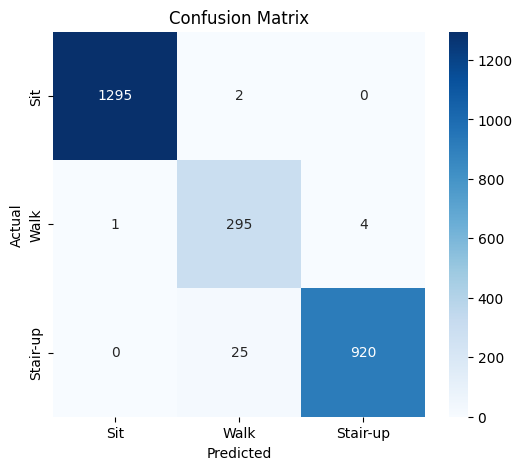

In [8]:
if __name__ == "__main__":
    train_and_evaluate()